#### Pakkar

In [1]:
# Our Libraries 
from ourModules import text_processor
from ourModules import toxic_comment_Classifier

/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
# Libraries ---------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from tensorflow.python.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.optimizers import Adadelta
import scipy.sparse
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
# # %tensorflow_version 1.x
# import tensorflow
# print(tensorflow.__version__)
import tensorflow as tf

In [4]:
tf.compat.v1.disable_eager_execution()

#### Innlestur gagna

In [5]:
train_data = pd.read_csv('data/train.csv',delimiter=',')
train_data.drop('id',axis=1,inplace=True) # Id er gagnslaust til ad spa
# test_labeled_data = pd.read_csv('data/test_labels.csv',delimiter=',') # Will most likely not be used



### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [6]:
# Nota þetta til að testa loka módelið
cols = list(train_data)
X_train_data = train_data.drop(columns = cols[1:])
y_train_data = train_data.drop(columns = cols[:1])

# 80/20 train/test split
# Mögulega þarf að nota sklearn.cross_validation.StratifiedShuffleSplit frekar til að halda svipuðu 
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=12)
X_train_np, X_test_np, y_train_np, y_test_np = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()


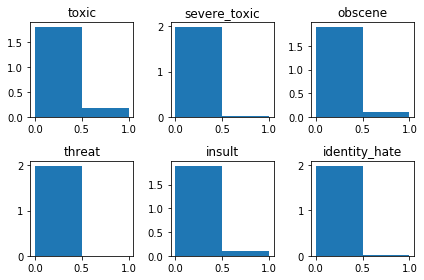

Number of instances marked with toxic: 	 12143/127656 or 9.51%
Number of instances marked with severe_toxic: 	 1265/127656 or 0.99%
Number of instances marked with obscene: 	 6714/127656 or 5.26%
Number of instances marked with threat: 	 387/127656 or 0.30%
Number of instances marked with insult: 	 6275/127656 or 4.92%
Number of instances marked with identity_hate: 	 1117/127656 or 0.88%


In [7]:
# Visualize distribution of y
n_bins = 2
fig, axes = plt.subplots(nrows=2, ncols=3)
axs = axes.flatten()
i = 0
for col in cols[1:]:
    axs[i].hist(y_train[col], n_bins, density=True, histtype='bar')
    axs[i].set_title(col)
    i +=1
fig.tight_layout()
plt.show()
# Notice skewed dataset
for col in cols[1:]:
    cnt = np.count_nonzero(y_train[col])
    print('Number of instances marked with {}: \t {}/{} or {:.2%}'.format(col, cnt,
                                                                    y_train_np.shape[0], cnt/y_train_np.shape[0]) )

In [8]:
n,m = y_train_np.shape
y_pred = np.zeros(n)

rowindx, colindx = np.nonzero(y_train_np)
rwi = np.unique(rowindx)
print('Number of rows with at least one none-zero value ', len(rwi))
non_zero_y_train = y_train_np[rwi]
for i in range(m):
    print('All-zero guess accuracy on data for {} is: {:.2%}'.format(cols[i+1], np.average(y_pred == y_train_np[:, i])))
    print('All-zero guess accuracy for {} but all-zero-rows removed is: {:.2%}'.format(cols[i+1],
                                                                np.average(y_pred[rwi] == non_zero_y_train[:, i])))
    print('-'*100)

y_pred_mat = np.zeros(y_train_np.shape) # All zero matrix
# Find how many lines are correctly classified
count_acc = np.sum(y_pred_mat == y_train_np, axis = 1)
print('All-zero guess row accuracy on data is: {:.2%}'.format(np.average(np.where(count_acc == 6, 1, 0), axis = 0)))

Number of rows with at least one none-zero value  12900
All-zero guess accuracy on data for toxic is: 90.49%
All-zero guess accuracy for toxic but all-zero-rows removed is: 5.87%
----------------------------------------------------------------------------------------------------
All-zero guess accuracy on data for severe_toxic is: 99.01%
All-zero guess accuracy for severe_toxic but all-zero-rows removed is: 90.19%
----------------------------------------------------------------------------------------------------
All-zero guess accuracy on data for obscene is: 94.74%
All-zero guess accuracy for obscene but all-zero-rows removed is: 47.95%
----------------------------------------------------------------------------------------------------
All-zero guess accuracy on data for threat is: 99.70%
All-zero guess accuracy for threat but all-zero-rows removed is: 97.00%
----------------------------------------------------------------------------------------------------
All-zero guess accuracy o

### State Vector Machine / Baseline Model




Lets build our first model. We start by making a simple SVM, which is widely regarded as one of the best text classification algorithms. This baseline classifier which treats the labels independently by training a binary classifier on each label separately. This initial model does not implement multilable classifaction in the best way nor does it take into account the skewed data.

In [92]:

# subsamples the data but makes sure all y columns include 2 classes
def data_subsample_asserts_two_classes(X, y, n):
    # Select a random subset of the training data
    max_tries = 15
    tries = 0
    while tries < max_tries:
        perm = np.random.permutation(len(y))
        X_sub=X[perm[0:n],:]
        y_sub=y[perm[0:n]]
        count = 0
        length = y_sub.shape[1]
        for i in range(length):
            # Make sure all columns have 2 classes
            if len(np.unique(y_sub[:,i])) < 2:
                break
            if i == (length-1):
                print('Data subsampling succsessful!')
                return X_sub, y_sub
        tries += 1
#         print("Data subsampling failed in {} try. Trying again.".format(tries) )
#         print('-'*100)
    print("Data subsampling failed in {} tries".format(max_tries))
    return 0,0


In [10]:
# Reduces training set while testing due to SVC being slow
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, 5000)
print("Number of training instances: ", X_train_reduced.shape[0] )

# Bag of words approach
# CountVectorizer has the benefit of producing a sparse representation of the counts 
vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
tfidf_transformer = TfidfTransformer()
# Get counts
X_train_counts = vectorizer.fit_transform(X_train_reduced.ravel())
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

acc = []
y_pred_lin = np.zeros(y_test_np.shape)
y_pred_rbf = np.zeros(y_test_np.shape)
for i in range(len(cols[1:])):
    for kernel_ in ['linear', 'rbf']:
        clf = SVC(kernel = kernel_, class_weight = 'balanced')
        clf.fit(X_train_tfidf, y_train_reduced[:,i])

        pred = clf.predict(vectorizer.transform(X_test_np.ravel()))
        a = np.average(pred == y_test[cols[i+1]]) #accuracy for this label
        if kernel_ == 'linear':
            y_pred_lin[:,i] = pred 
        else:
            y_pred_rbf[:,i] = pred 

        acc = np.append(acc, a)

        print('SVC-{} accuracy on {}: {:.2%} '.format(kernel_, cols[i+1], a))
    print('-'*100)

# Find how many lines are correctly classified
lin_acc = np.sum(y_pred_lin == y_test_np, axis = 1)
rbf_acc = np.sum(y_pred_rbf == y_test_np, axis = 1)
print('SVM-linear row accuracy: {:.2%}'.format(np.average(np.where(lin_acc == 6, 1, 0), axis = 0)))
print('SVM-rbf row accuracy: {:.2%}'.format(np.average(np.where(rbf_acc == 6, 1, 0), axis = 0)))

for preds in [y_pred_lin, y_pred_rbf]:
    rowindx, colindx = np.nonzero(preds)
    tmp1 = len(np.unique(rowindx))
    tmp2 = preds.shape[0]
    print('Number of non-zero row guesses: {}/{} = {:.2%}'.format(tmp1, tmp2, tmp1/tmp2 ) )

Data subsampling succsessful!
Number of training instances:  5000
SVC-linear accuracy on toxic: 89.05% 


KeyboardInterrupt: 

In [ ]:
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, 5000)
print("Number of training instances: ", X_train_reduced.shape[0] )

# Bag of words approach
# CountVectorizer has the benefit of producing a sparse representation of the counts 
vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_train_reduced.ravel())
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


clf = OneVsRestClassifier(SVC(kernel='rbf', class_weight = 'balanced'))
clf.fit(X_train_tfidf, y_train_reduced)
pred = clf.predict( vectorizer.transform(X_test_np.ravel()) )
acc = np.sum(pred == y_test_np, axis = 1)
print('SVM-rbf row accuracy: {:.2%}'.format(np.average(np.where(acc == 6, 1, 0), axis = 0)))
clf = MultiOutputClassifier(SVC(kernel = 'rbf', class_weight = 'balanced'))
clf.fit(X_train_tfidf, y_train_reduced)
print('Done training')
# pred = clf.predict( vectorizer.transform(X_test_np.ravel()) )
# acc = np.sum(pred == y_test_np, axis = 1)
# print('SVM-rbf row accuracy: {:.2%}'.format(np.average(np.where(acc == 6, 1, 0), axis = 0)))



In [166]:
def get_row_accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred, axis = 1)
    return np.average(np.where(acc == 6, 1, 0), axis = 0)

def plot_acc_params(param, train_acc_, val_acc_, param_name, title):
    plt.plot(param, train_acc_,label='Training accuracy')
    plt.plot(param, val_acc_,label='Validation accuracy')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def find_SVM_params(params, ptype, kernel_, xtrain, ytrain, xval, yval):
    training_acc = []
    val_acc = []
    for param in params:
        if ptype == 'C':
            clf = OneVsRestClassifier(SVC(C = param,
                                      kernel=kernel_, class_weight = 'balanced'))
        if ptype == 'gamma':
            clf = OneVsRestClassifier(SVC(gamma=param,
                                      kernel=kernel_, class_weight = 'balanced'))
        clf.fit(xtrain, ytrain)

        t_acc = get_row_accuracy(ytrain, clf.predict(xtrain))
        v_acc = get_row_accuracy(yval, clf.predict(xval))

        training_acc.append(t_acc)
        val_acc.append(v_acc)
        print('Parameter: {} Training acc: {:.2%}, Validation acc: {:.2%}'.format(param, t_acc, v_acc))
    print('-'*100)
    return training_acc, val_acc

def find_best_SVM_params(Cs, gammas, kernel_, xtrain, ytrain, xval, yval):
    training_acc = np.zeros(len(Cs))
    val_acc = np.zeros(len(Cs))
    if kernel_ != 'linear':
        training_acc = np.zeros((len(Cs), len(gammas)))
        val_acc = np.zeros((len(Cs), len(gammas)))
    
    for i in range(len(Cs)):
        print("c: ", Cs[i])
        if kernel_ != 'linear':
            for j in range(len(gammas)):
                print("gamma: ", gammas[j], end =" ")
                clf = OneVsRestClassifier(SVC(gamma=gammas[j], C = Cs[i], kernel = kernel_))
                clf.fit(xtrain, ytrain)
                val_acc[i, j] = get_row_accuracy(yval, clf.predict(xval))
                training_acc[i, j] = get_row_accuracy(ytrain, clf.predict(xtrain))
        else:
            clf = OneVsRestClassifier(SVC(C = Cs[i], kernel = kernel_))
            clf.fit(xtrain, ytrain)
            val_acc[i] = get_row_accuracy(yval, clf.predict(xval))
            training_acc[i] = get_row_accuracy(ytrain, clf.predict(xtrain))
        print()
#     print('Train acc \n', training_acc)
#     print('Validation acc \n', val_acc)
    return training_acc, val_acc

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_heatmap(data_matrix, title, xlabel, ylabel, x_values, y_values, vmin_, midpoint_):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=vmin_, midpoint=midpoint_))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.xticks(np.arange(len(x_values)), x_values, rotation=45)
    plt.yticks(np.arange(len(y_values)), y_values)
    plt.title(title)
    plt.show()


Data subsampling succsessful!
Number of training instances:  5000
----------------------------------------------------------------------------------------------------
Using kernel  rbf
Testing parameters, C: [  0.1   1.   10.  100. ],
gamma: [1.    0.1   0.01  0.001]
c:  0.1
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  1.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  10.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  100.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
----------------------------------------------------------------------------------------------------
Using kernel  linear
Testing parameters, C: [  0.1   1.   10.  100. ],
gamma: [1.    0.1   0.01  0.001]
c:  0.1

c:  1.0

c:  10.0

c:  100.0

For rbf kernal
Optimal combination is,  C: 100.0, gamma: 0.001
Giving the validation accuracy: 90.90%
For linear kernal
Optimal C is: 0.1
Giving the validation accuracy: 90.44%


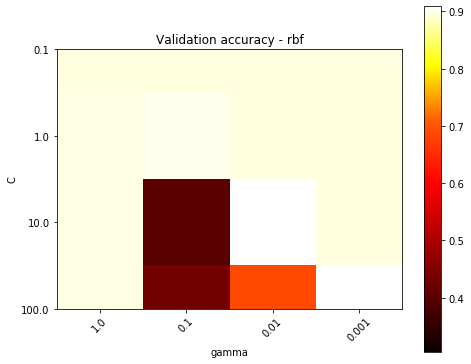

In [227]:

X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, 5000)
print("Number of training instances: ", X_train_reduced.shape[0] )

# Bag of words approach
# CountVectorizer has the benefit of producing a sparse representation of the counts 
vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_train_reduced.ravel())
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# Rough search for a good estimate of C and gamma
x_test_unrvld = vectorizer.transform(X_test_np.ravel())

C = 0.1* np.power(10,np.arange(4))
gamma = 1/np.power(10,np.arange(4))

accs = { 'val_acc': {'rbf': np.zeros((len(C), len(gamma))),
                     'linear': np.zeros(len(C)) },
        'train_acc': {'rbf': np.zeros((len(C), len(gamma))),
                     'linear': np.zeros(len(C)) } 
       }
kernels = ['rbf', 'linear']
for kernel in kernels:
    print('-'*100)
    print('Using kernel ', kernel)
    print('Testing parameters, C: {},\ngamma: {}'.format(C, gamma))
    tA, vA = find_best_SVM_params(C, gamma, kernel,
                                     X_train_tfidf, y_train_reduced,
                                     x_test_unrvld, y_test_np)
    accs['train_acc'][kernel] = tA
    accs['val_acc'][kernel] = vA

rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
print('For rbf kernal')
rbfOptparam = C[Cind], gamma[gammaind]
print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
print("Giving the validation accuracy: {:.2%}".format(rbfacc[Cind, gammaind]))

Cindex = np.argmax(linacc)
linearOptC = C[Cindex]
print('For linear kernal')
print("Optimal C is: {}".format(linearOptC))
print("Giving the validation accuracy: {:.2%}".format(linacc[Cindex]))
plot_heatmap(rbfacc, 'Validation accuracy - rbf', 'gamma', 'C', gamma, C,
             np.min(rbfacc) - 0.1, np.max(rbfacc)-0.2)

[[0.89603635 0.89581701 0.89581701 0.89581701]
 [0.89660034 0.900799   0.89619301 0.89581701]
 [0.89675701 0.40551465 0.90888297 0.89638101]
 [0.89675701 0.43217923 0.6893937  0.90897697]]
0.9089769700767664


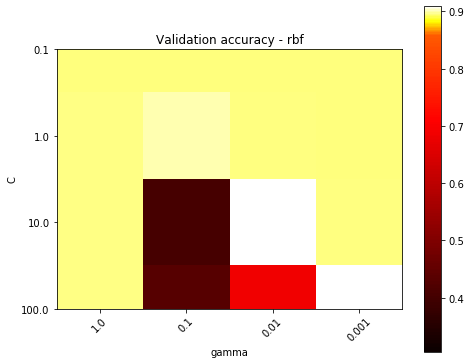

In [231]:
plot_heatmap(rbfacc, 'Validation accuracy - rbf', 'gamma', 'C', gamma, C,
             np.min(rbfacc) - 0.1, np.max(rbfacc)-0.05)

In [108]:

        
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, 100)
print("Number of training instances: ", X_train_reduced.shape[0] )

# Bag of words approach
# CountVectorizer has the benefit of producing a sparse representation of the counts 
vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_train_reduced.ravel())
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# Rough search for a good estimate of C and gamma
x_test_unrvld = vectorizer.transform(X_test_np.ravel())

C = 0.1* np.power(10,np.arange(2))
gamma = 1/np.power(10,np.arange(2))

kernels_ = {'rbf': { 'gamma': gamma,'C': C},
            'linear': {'gamma': [], 'C': C}}

accs = { 'val_acc': {'rbf': {'C' : [], 'gamma' : []},
                     'linear': {'C' : [], 'gamma' : []}
                    },
        'train_acc': {'rbf': {'C' : [], 'gamma' : []},
                     'linear': {'C' : [], 'gamma' : []}} 
       }
params = ['C', 'gamma']
for k in kernels_:
    for p in params:
        # k = string kernel_name
        # kernel_ = dictionary with testing parameters
        kernel_ = kernels_[k]
        par_list = kernel_[p]
        print('-'*100)
        print('Using kernel ', k)
        print('Testing parameter, {}: {}'.format(p, par_list))

        accs['train_acc'][k][p], accs['val_acc'][k][p] = find_SVM_params(par_list, p, k,
                                         X_train_tfidf, y_train_reduced,
                                         x_test_unrvld, y_test_np)
opt_Linear_C = C[np.argmax(accs['val_acc']['linear']['C'])]
opt_rbf_C = C[np.argmax(accs['val_acc']['rbf']['C'])]
opt_rbf_gamma = gamma[np.argmax(accs['val_acc']['rbf']['gamma'])]

print("Optimal value of C for validation set on linear kernel:", opt_Linear_C)
print("Optimal value of gamma for validation set on rbf kernel:", opt_rbf_gamma)
print("Optimal value of C for validation set on rbf kernel:", opt_rbf_C)

Data subsampling succsessful!
Number of training instances:  1000
----------------------------------------------------------------------------------------------------
Using kernel  rbf
Testing parameter, C: [  0.1   1.   10.  100. ]
Parameter: 0.1 Training acc: 95.30%, Validation acc: 89.62%
Parameter: 1.0 Training acc: 99.40%, Validation acc: 89.61%
Parameter: 10.0 Training acc: 99.80%, Validation acc: 89.63%
Parameter: 100.0 Training acc: 100.00%, Validation acc: 89.63%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Using kernel  rbf
Testing parameter, gamma: [1.    0.1   0.01  0.001]
Parameter: 1.0 Training acc: 99.40%, Validation acc: 89.61%
Parameter: 0.1 Training acc: 97.20%, Validation acc: 86.83%
Parameter: 0.01 Training acc: 2.70%, Validation acc: 45.51%
Parameter: 0.001 Training acc: 0.00%, Validation acc: 0.01%
-----------

KeyboardInterrupt: 

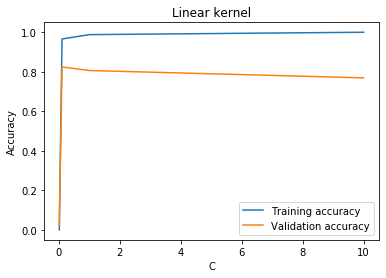

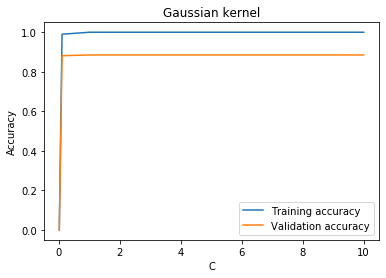

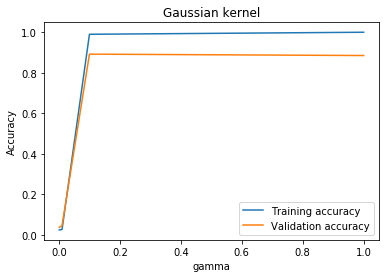

In [107]:
opt_Linear_C = accs['val_acc']['linear']['C']
opt_rbf_C = accs['val_acc']['rbf']['C']
opt_rbf_gamma = accs['val_acc']['rbf']['gamma']

plot_acc_params(C, accs['train_acc']['linear']['C'], accs['val_acc']['linear']['C'], 'C', 'Linear kernel')
plot_acc_params(C, accs['train_acc']['rbf']['C'], accs['val_acc']['rbf']['C'], 'C', 'Gaussian kernel')
plot_acc_params(gamma, accs['train_acc']['rbf']['gamma'], accs['val_acc']['rbf']['gamma'], 'gamma', 'Gaussian kernel')

# plot_acc_params(gamma_, training_acc, val_acc, 'gamma')

### Text preprocessing


Hér er þá búið að preprocessa textann

In [9]:
def getProcessedText(dataset):
    x_train = dataset['comment_text'].to_numpy()
    for i in range(len(x_train)):
        x_train[i] = textpreprocess(x_train[i])
    return x_train

In [10]:
x_train = train_data['comment_text'].to_numpy()
for i in range(len(x_train)):
    x_train[i] = text_processor.textPreprocess(x_train[i])

In [11]:
max_comment_length = len(train_data['comment_text'][0])

for comment in train_data['comment_text']:
    if len(comment) > maxlen:
        max_comment_length = len(comment)
print(maxlen)

NameError: name 'maxlen' is not defined

Prófa að exclude-a bara toxic dálkinn og gera model á honum

In [ ]:
toxicCol = train_data['toxic']
classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

In [ ]:
# X_train = train_data['comment_text'].to_numpy()
X_train = x_train
# y_train = (train_data.values[:,2:])
y_train = toxicCol
print(len(toxicCol), len(X_train))
# Set aside validation data for monitoring training progress

assert len(X_train) == len(y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

In [ ]:
max_words = 20000 # <- spurning um hvað þetta eigi að vera

tokenizer = text.Tokenizer(num_words=max_words)
num_classes = 6

tokenizer.fit_on_texts(list(X_train))
tokTrain = tokenizer.texts_to_sequences(X_train)
tokTest = tokenizer.texts_to_sequences(X_test)

x_train=sequence.pad_sequences(tokTrain, maxlen=max_comment_length)
x_test=sequence.pad_sequences(tokTest, maxlen=max_comment_length)


In [ ]:
model = Sequential()
model.add(Dense(512,input_shape=(max_comment_length,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(optimizer=Adadelta(),
          loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 2
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test acc: {}'.format(score[1]))